# Pandas 5:  Summarizing data  

Another in a series of notebooks that describe Pandas' powerful data management tools.  In this one we summarize our data in a variety of ways.  Which is more interesting than it sounds.  

Outline:  

* [WEO government debt data](#weo).  Something to work with. How does Argentina's government debt compare to the debt of other countries?  How did it compare when it defaulted in 2001?  
* [Describing numerical data](#describe).  Descriptive statistics:  numbers of non-missing values, mean, median, quantiles.  
* [Describing catgorical data](#value-counts). The excellent `value_counts` method.  
* [Grouping data](#groupby).  An incredibly useful collection of tools based on grouping data based on a variable:  men and woman, grads and undergrads, and so on.  

**Note: requires internet access to run.**  

This IPython notebook was created by Dave Backus, Chase Coleman, and Spencer Lyon for the NYU Stern course [Data Bootcamp](http://databootcamp.nyuecon.com/).  

<a id=prelims></a>

## Preliminaries 

Import packages, etc.  

In [2]:
import sys                             # system module 
import pandas as pd                    # data package
import matplotlib.pyplot as plt        # graphics module  
import datetime as dt                  # date and time module
import numpy as np                     # foundation for Pandas 

%matplotlib inline                     

# check versions (overkill, but why not?)
print('Python version:', sys.version)
print('Pandas version: ', pd.__version__)
print('Today: ', dt.date.today())

Python version: 3.5.1 |Anaconda 4.0.0 (64-bit)| (default, Feb 16 2016, 09:49:46) [MSC v.1900 64 bit (AMD64)]
Pandas version:  0.18.0
Today:  2016-04-20


<a id=weo></a>

## WEO data on government debt 

We use the IMF's data on government debt again, specifically its [World Economic Outlook database](https://www.imf.org/external/ns/cs.aspx?id=28), commonly referred to as the WEO.  We focus on government debt expressed as a percentage of GDP,  variable code `GGXWDG_NGDP`.   

The central question here is how the debt of Argentina, which defaulted in 2001, compared to other countries.  Was it a matter of too much debt or something else?  

### Load data

First step:  load the data and extract a single variable:  government debt (code `GGXWDG_NGDP`) expressed as a percentage of GDP.    

In [4]:
url1 = 'http://www.imf.org/external/pubs/ft/weo/2015/02/weodata/'
url2 = 'WEOOct2015all.xls'
url = url1 + url2 
weo = pd.read_csv(url, sep='\t', 
                  usecols=[1,2] + list(range(19,45)), 
                  thousands=',', 
                  na_values=['n/a', '--']) 
print('Variable dtypes:\n', weo.dtypes.head(6), sep='')

Variable dtypes:
ISO                  object
WEO Subject Code     object
1990                float64
1991                float64
1992                float64
1993                float64
dtype: object


### Clean and shape 

Second step:  select the variable we want and generate the two dataframes.  

In [5]:
# select debt variable 
variables = ['GGXWDG_NGDP']
db = weo[weo['WEO Subject Code'].isin(variables)]

# drop variable code column (they're all the same) 
db = db.drop('WEO Subject Code', axis=1)

# set index to country code 
db = db.set_index('ISO')

# name columns 
db.columns.name = 'Year'

# transpose 
dbt = db.T

# see what we have 
dbt.head()

ISO,AFG,ALB,DZA,AGO,ATG,ARG,ARM,AUS,AUT,AZE,...,GBR,USA,URY,UZB,VUT,VEN,VNM,YEM,ZMB,ZWE
Year,,,,,,,,,,,,,,,,,,,,,
1990,NaN,NaN,NaN,NaN,98.071,NaN,NaN,16.442,56.057,NaN,...,31.029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991,NaN,NaN,77.834,NaN,99.075,NaN,NaN,21.627,56.260,NaN,...,31.026,NaN,NaN,NaN,15.908,NaN,NaN,NaN,NaN,NaN
1992,NaN,NaN,62.926,NaN,95.479,23.309,NaN,27.650,56.153,NaN,...,36.129,NaN,NaN,NaN,21.036,NaN,NaN,NaN,NaN,NaN
1993,NaN,NaN,74.028,NaN,90.147,25.113,NaN,30.650,60.765,NaN,...,41.292,NaN,NaN,NaN,20.274,NaN,NaN,NaN,NaN,NaN
1994,NaN,NaN,98.376,NaN,89.655,26.536,NaN,31.763,63.863,NaN,...,44.309,NaN,NaN,NaN,21.599,NaN,NaN,NaN,NaN,NaN


**Example.** Let's try a simple graph of the dataframe `dbt`.  The goal is to put Argentina in perspective by plotting it along with many other countries.  

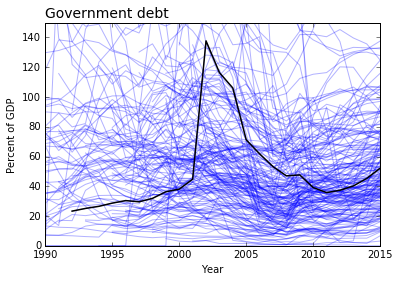

In [9]:
fig, ax = plt.subplots()
dbt.plot(ax=ax, 
         legend=False, color='blue', alpha=0.3, 
         ylim=(0,150)
        )
ax.set_ylabel('Percent of GDP')
ax.set_xlabel('')
ax.set_title('Government debt', fontsize=14, loc='left')
dbt['ARG'].plot(ax=ax, color='black', linewidth=1.5)

**Exercise.** 

* What do you take away from this graph?  
* What would you change to make it look better?
* To make it mnore informative?
* To put Argentina's debt in context?  

**Exercise.** Do the same graph with Greece (GRC) as the country of interest.  How does it differ?  Why do you think that is?  

<a id=describe></a>

## Describing numerical data 

Let's step back a minute.  What we're trying to do is compare Argentina to other countries.  What's the best way to do that?  This isn't a question with an obvious best answer, but we can try some things, see how they look.  One thing we could do is compare Argentina to the mean or median.  Or to some other feature of the distribution.  

We work up to this by looking first at some features of the distribution of government debt numbers across countries.  Some of this we've seen, so is new.  

### What's (not) there?

Let's check out the data first.  How many non-missing values do we have at each date?   We can do that with the `count` method. The argument `axis=1` says to do this by date, counting across columns (axis number 1).  

In [6]:
dbt.shape

(26, 189)

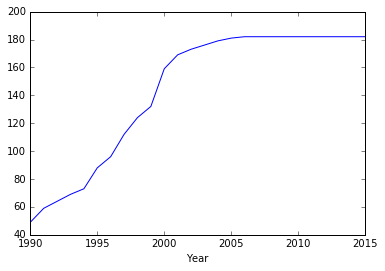

In [20]:
# count non-missing values 
dbt.count(axis=1).plot()

### Describing series 

Let's take the data for 2001 -- the year of Argentina's default -- and see what how Argentina compares.  Was its debt high compare to other countries?  

which leads to more questions.  How would we compare?  Compare Argentina to the mean or median?  Something else?  

Let's see how that works.  

In [10]:
# 2001 data 
db01 = db['2001'] 

In [11]:
db01['ARG']

44.756999999999998

In [12]:
db01.mean()

72.91579881656806

In [13]:
db01.median()

56.523999999999994

In [14]:
db01.describe()

count    169.000000
mean      72.915799
std       72.257092
min        0.000000
25%       36.968000
50%       56.524000
75%       93.769000
max      612.226000
Name: 2001, dtype: float64

In [15]:
db01.quantile(q=[0.25, 0.5, 0.75])

0.25    36.968
0.50    56.524
0.75    93.769
Name: 2001, dtype: float64

**Comment.** If we add enough quantiles, we might as well plot the whole distribution.  The easiest way to do this is with a histogram.  

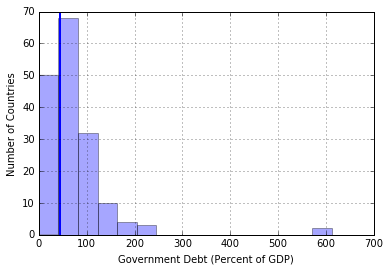

In [16]:
fig, ax = plt.subplots()
db01.hist(bins=15, ax=ax, alpha=0.35)
ax.set_xlabel('Government Debt (Percent of GDP)')
ax.set_ylabel('Number of Countries')

darg = db01['ARG'] 
ymin, ymax = ax.get_ylim()
ax.vlines(darg, ymin, ymax, color='blue', lw=2) 

### Describing dataframes

We can compute the same statistics for dataframes.  Here we hve a choice:  we can compute (say) the mean down rows (`axis=0`) or across columns (`axis=1`).  If we use the dataframe `dbt`, computing the mean across countries (columns) calls for `axis=1`.

In [21]:
# here we compute the mean across countries at every date
dbt.mean(axis=1).head()

Year
1990    66.487102
1991    66.227729
1992    69.696406
1993    68.236130
1994    69.928247
dtype: float64

In [22]:
# or we could do the median
dbt.median(axis=1).head()

Year
1990    56.482
1991    56.856
1992    55.624
1993    58.599
1994    59.735
dtype: float64

In [23]:
# or a bunch of stats at once 
# NB:  db not dbt (there's no axix argument here)
db.describe()

Year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
count,49.000000,59.000000,64.000000,69.000000,73.000000,88.000000,96.000000,112.000000,124.000000,132.000000,...,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000
mean,66.487102,66.227729,69.696406,68.236130,69.928247,62.102545,56.744188,56.986161,58.682137,59.659538,...,53.035082,46.838967,45.018973,47.706577,46.481049,46.683604,47.686456,49.210324,51.306412,54.344247
std,55.489269,49.025392,62.713445,45.234081,53.652731,40.891238,37.642378,34.630448,38.194130,36.556886,...,56.775113,46.953668,38.423596,33.993966,31.753314,33.059382,33.386893,33.999834,33.904244,33.923656
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.593000,0.684000,0.585000,0.671000,0.665000,0.000000,0.576000,0.546000,0.069000,0.062000
25%,28.353000,33.583000,35.971250,41.292000,43.052000,30.766750,28.317250,29.401250,30.370750,32.680750,...,24.022750,21.209500,20.597750,25.888250,25.907000,24.616000,26.516250,28.047750,29.655000,32.763500
50%,56.482000,56.856000,55.624000,58.599000,59.735000,57.001000,53.500500,53.802500,53.690000,56.354000,...,39.138000,35.747500,36.552500,39.440500,39.649000,39.139500,40.073000,40.070500,43.361000,47.370000
75%,80.353000,85.518500,86.676000,90.135000,87.985000,86.854000,73.508250,74.393000,75.460750,82.958500,...,65.469000,62.184750,60.010250,63.158250,61.114500,61.253000,62.716500,64.636000,67.710000,70.120000
max,243.429000,203.364000,454.949000,262.657000,355.061000,219.593000,202.885000,156.196000,173.560000,164.268000,...,593.515000,482.764000,309.660000,210.247000,215.821000,229.706000,236.649000,242.593000,246.173000,245.896000


In [24]:
# the other way 
dbt.describe()

ISO,AFG,ALB,DZA,AGO,ATG,ARG,ARM,AUS,AUT,AZE,...,GBR,USA,URY,UZB,VUT,VEN,VNM,YEM,ZMB,ZWE
count,0.0,19.000000,25.000000,16.000000,26.000000,24.000000,20.000000,26.000000,26.000000,21.000000,...,26.000000,15.000000,15.000000,18.000000,25.000000,18.000000,16.000000,17.000000,16.000000,11.000000
mean,NaN,62.007789,46.233680,47.985750,99.331308,50.230958,33.859000,21.928846,69.135846,15.938619,...,52.135808,79.630533,72.594800,24.253167,24.902960,40.506000,43.055188,52.637941,24.360500,56.294091
std,NaN,6.104841,34.091374,26.904972,13.553858,29.697460,10.162803,8.135018,9.050139,5.588846,...,19.653787,20.306936,18.642755,16.621395,6.588914,11.230156,8.742659,13.964724,6.610021,10.191885
min,NaN,53.427000,8.278000,16.426000,77.271000,23.309000,14.249000,9.677000,56.057000,7.297000,...,31.026000,53.022000,54.890000,8.276000,15.908000,23.099000,31.432000,36.421000,16.718000,38.576000
25%,NaN,57.582000,10.814000,30.740500,90.803500,31.498000,31.268000,15.407000,64.097750,11.599000,...,39.336750,63.825000,59.798500,10.216000,20.568000,31.966250,37.220000,43.801000,20.207000,50.936500
50%,NaN,59.667000,44.535000,40.515500,96.786500,39.686000,37.150500,22.107500,66.455000,14.291000,...,43.923000,72.835000,64.067000,18.563000,22.162000,39.192000,40.158000,48.722000,21.912500,54.230000
75%,NaN,66.391000,72.863000,59.234000,104.104500,52.408750,39.717000,28.952250,76.924000,20.603000,...,62.298500,100.743000,79.808000,33.685750,28.046000,50.253000,48.215750,57.827000,26.263500,65.743000
max,NaN,73.305000,116.195000,104.542000,128.165000,137.715000,46.503000,35.972000,86.712000,25.414000,...,89.397000,104.853000,111.546000,59.375000,38.806000,61.443000,61.215000,96.050000,41.892000,69.291000


**Example.** Let's add the mean to our graph.  We make it a dashed line with `linestyle='dashed'`.  

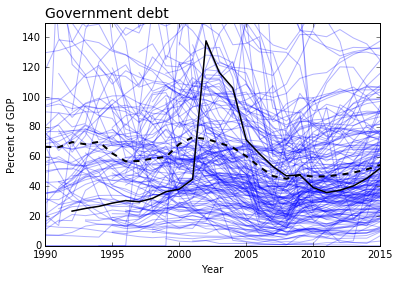

In [25]:
fig, ax = plt.subplots()
dbt.plot(ax=ax, 
         legend=False, color='blue', alpha=0.3, 
         ylim=(0,150)
        )
dbt['ARG'].plot(ax=ax, color='black', linewidth=1.5)
ax.set_ylabel('Percent of GDP')
ax.set_xlabel('')
ax.set_title('Government debt', fontsize=14, loc='left')
dbt.mean(axis=1).plot(ax=ax, color='black', linewidth=2, linestyle='dashed')

**Question.** Do you think this looks better when the mean varies with time, or when we use a constant mean?  Let's try it and see.  

In [26]:
dbar = dbt.mean().mean()
dbar

57.044499497307044

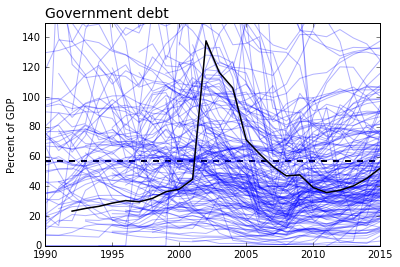

In [27]:
fig, ax = plt.subplots()
dbt.plot(ax=ax, 
         legend=False, color='blue', alpha=0.3, 
         ylim=(0,150)
        )
dbt['ARG'].plot(ax=ax, color='black', linewidth=1.5)
ax.set_ylabel('Percent of GDP')
ax.set_xlabel('')
ax.set_title('Government debt', fontsize=14, loc='left') 
xmin, xmax = ax.get_xlim()
ax.hlines(dbar, xmin, xmax, linewidth=2, linestyle='dashed')

**Exercise.** Which do we like better?

**Exercise.** Replace the (constant) mean with the (constant) median?  Which do you prefer?  

<a id=value-counts></a>

## Describing categorical data 

A **categorical variable** is one that takes on a small number of values.  States take on one of fifty values.  University students are either grad or undergrad.  Students select majors and concentrations.  

We're going to do two things with categorical data:  

* In this section, we count the number of observations in each category using the `value_counts` method. This is a series method, we apply it to one series/variable at a time.   
* In the next section, we go on to describe how other variables differ across catagories.  How do students who major in finance differ from those who major in English?  And so on.  

We start with the combined MovieLens data we constructed in the previous notebook.  

In [30]:
url = 'http://pages.stern.nyu.edu/~dbackus/Data/mlcombined.csv'
ml  = pd.read_csv(url)
print('Dimensions:', ml.shape)
ml.head(10)

Dimensions: (105339, 7)


,Unnamed: 0,userId,movieId,rating,timestamp,title,genres
0,0,1,16,4.0,1217897793,Casino (1995),Crime|Drama
1,1,1,24,1.5,1217895807,Powder (1995),Drama|Sci-Fi
2,2,1,32,4.0,1217896246,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,3,1,47,4.0,1217896556,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,4,1,50,4.0,1217896523,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
5,5,1,110,4.0,1217896150,Braveheart (1995),Action|Drama|War
6,6,1,150,3.0,1217895940,Apollo 13 (1995),Adventure|Drama|IMAX
7,7,1,161,4.0,1217897864,Crimson Tide (1995),Drama|Thriller|War
8,8,1,165,3.0,1217897135,Die Hard: With a Vengeance (1995),Action|Crime|Thriller
9,9,1,204,0.5,1217895786,Under Siege 2: Dark Territory (1995),Action


In [32]:
# which movies have the most ratings? 
ml['title'].value_counts().head(10)

Pulp Fiction (1994)                          325
Forrest Gump (1994)                          311
Shawshank Redemption, The (1994)             308
Jurassic Park (1993)                         294
Silence of the Lambs, The (1991)             290
Star Wars: Episode IV - A New Hope (1977)    273
Matrix, The (1999)                           261
Terminator 2: Judgment Day (1991)            253
Schindler's List (1993)                      248
Braveheart (1995)                            248
Name: title, dtype: int64

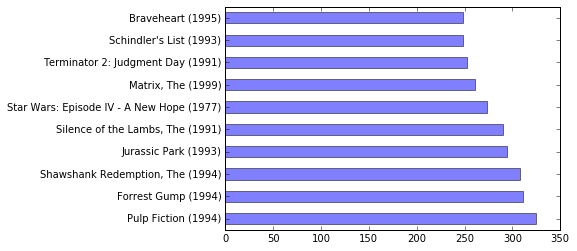

In [41]:
ml['title'].value_counts().head(10).plot.barh(alpha=0.5)

In [42]:
# which people have rated the most movies?
ml['userId'].value_counts().head(10)

668    5678
575    2837
458    2086
232    1421
310    1287
475    1249
128    1231
224    1182
607    1176
63     1107
Name: userId, dtype: int64

<a id=groupby></a>

## Grouping data 

Next up:  group data by some variable.  As an example, how would we compute the average rating of each movie?  If you think for a minute, you might think of these steps:

* Group the data by movie:  Put all the "Pulp Fiction" ratings in one bin, all the "Shawshank" ratings in another.  We do that with the `groupby` method. 
* Compute a statistic (the mean, for example) for each group.  

Pandas has tools that make that relatively easy.  

In [43]:
# group 
g = ml[['title', 'rating']].groupby('title')
type(g)

pandas.core.groupby.DataFrameGroupBy

Now that we have a groupby object, what can we do with it?  

In [50]:
# the number in each category
g.count().head(10)

,rating
title,
'71 (2014),1
'Hellboy': The Seeds of Creation (2004),1
'Round Midnight (1986),1
'Til There Was You (1997),3
"'burbs, The (1989)",20
'night Mother (1986),1
(500) Days of Summer (2009),37
*batteries not included (1987),11
...And Justice for All (1979),10


In [48]:
# what type of object have we created?
type(g.count())

pandas.core.frame.DataFrame

**Add this via Spencer.**

**Comment.** Note that the combination of `groupby` and `count` created a dataframe with

* Its index is the variable we grouped by.  If we group by more than one, we get a multi-index.
* Its columns are the other variables.  

**Exercise.**  Take the code 

```python
counts = ml.groupby(['title', 'movieId')
```

Without running it, what is the index of `counts`?  What are its columns?  

In [46]:
gm = g.mean()
gm.head(10)

,rating
title,
'71 (2014),3.500000
'Hellboy': The Seeds of Creation (2004),3.000000
'Round Midnight (1986),2.500000
'Til There Was You (1997),4.000000
"'burbs, The (1989)",3.125000
'night Mother (1986),3.000000
(500) Days of Summer (2009),3.932432
*batteries not included (1987),3.318182
...And Justice for All (1979),3.650000


In [59]:
# we can put them together 
grouped = g.count()
grouped = grouped.rename(columns={'rating': 'Number'})
grouped['Mean'] = g.mean()
grouped.head(10)

,Number,Mean
title,,
'71 (2014),1,3.500000
'Hellboy': The Seeds of Creation (2004),1,3.000000
'Round Midnight (1986),1,2.500000
'Til There Was You (1997),3,4.000000
"'burbs, The (1989)",20,3.125000
'night Mother (1986),1,3.000000
(500) Days of Summer (2009),37,3.932432
*batteries not included (1987),11,3.318182
...And Justice for All (1979),10,3.650000


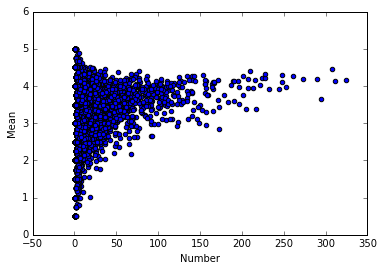

In [63]:
grouped.plot.scatter(x='Number', y='Mean')

**Exercise.** Compute the median and add it to the dataframe.  

## Resources

The [Brandon Rhodes video](https://youtu.be/5JnMutdy6Fw) covers most of this, too.  